# Estimating the overdispersion parameter (`rho`) for beta-binomial from two replicates of input
I fit the model in R using VGAM, then look at the fit in python in another notebook!

`rho` estimates the variability between replicates. The greater the number, the more different the two reps are!
## I tried multiple ways to find the best fitting `rho`!
- read_rep1, read_rep2 ~ 1 Using all data
- read_rep1, read_rep2 ~ fraction_read_rep1
- read_rep1, read_rep2 ~ 1 Using only circular RNAs with >0 reads in both replicates

## In the end, the third method yielded the best fitting rho (shown in another notebook)

In [1]:
library(tidyverse)
counts = read_tsv('/home/hsher/scratch/rar11_input.tsv')
head(counts)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0
Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tibble’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
Warning message:
“package ‘forcats’ was built under R version 4.2.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
New names:
• `` -> `...1`
Rows: 125726 Columns: 25
── Column specification

...1,seqname,source,feature,start,end,strand,frame,circ_id,circ_type,⋯,BSJ-PP_Polysome1,BSJ-PP_Polysome2,BSJ-PP_Input2,BSJ-PP_Monosome1,FSJ-PP_Input1,FSJ-PP_Monosome2,FSJ-PP_Polysome1,FSJ-PP_Polysome2,FSJ-PP_Input2,FSJ-PP_Monosome1
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,chr1,CIRIquant,circRNA,746695,749381,-,.,chr1:746695|749381,intron,⋯,0,0,24,0,4,0,0,0,42,0
1,chr1,CIRIquant,circRNA,805799,810170,-,.,chr1:805799|810170,exon,⋯,0,9,34,11,8,0,0,3,16,1
2,chr1,CIRIquant,circRNA,915319,915949,+,.,chr1:915319|915949,intron,⋯,0,0,1,0,51,0,0,0,43,0
3,chr1,CIRIquant,circRNA,955923,957273,-,.,chr1:955923|957273,exon,⋯,0,0,2,0,222,15,0,0,220,0
4,chr1,CIRIquant,circRNA,1084353,1086012,-,.,chr1:1084353|1086012,exon,⋯,0,0,0,0,30,0,0,0,0,0
5,chr1,CIRIquant,circRNA,1223244,1223968,-,.,chr1:1223244|1223968,exon,⋯,53,43,296,178,739,553,317,923,779,816


The above is the data.
There are a couple datasets, 
- "Polysome"/"Monosome" can be thought of as "IP"
- "Input" are the "IN"
We are **trying to find circular RNAs enriched in the IP fraction**,

circular RNAs are characterized by back-splicing junctions (BSJ). 

The BSJ reads either present in IP or IN. A binary outcome makes me think binomial.
We model it this way:

number reads in IP, number reads in IN ~ Binomial (mu)

In the past we know CLIP is more variable than we thought, so we would like to use a overdispersed version of binomial: beta-binomial.

Beta-binomial is parameterized by not only "mu" but also "rho".

Fitting overdispersion is a pain in the ass. Skipper sorta figure the best way to fit is to infer between replicates. Not sure how this would be done in STAMP. This is what im doing here.

In [3]:

sample_pairs = c('PP_Input1','PP_Input2')
rep1 = paste0('BSJ-',sample_pairs[1])
rep2 = paste0('BSJ-',sample_pairs[2])


print(paste('estimating variance between: ',rep1, rep2))

counts$total_reads=counts[[rep1]]+counts[[rep2]]
sub_counts = counts[counts$total_reads>0,] 
sub_counts$p_bsj_rep1 = sub_counts[[rep1]]/(sub_counts[[rep1]]+sub_counts[[rep2]])

[1] "estimating variance between:  BSJ-PP_Input1 BSJ-PP_Input2"


In [4]:
# read_rep1, read_rep2 ~ fraction of read in rep1, ALL data
# THIS IS THE FITTING

betabinom_fit = VGAM::vglm(cbind(sub_counts[[rep1]], sub_counts[[rep2]]) ~ sub_counts$p_bsj_rep1 ,
                           VGAM::betabinomial(), trace = TRUE) # rho as a function to total reads
print(betabinom_fit %>% (VGAM::Coef)%>% as_tibble(rownames="coef"))

Warning message in checkwz(wz, M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  1 :  loglikelihood = -113107.4869


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  2 :  loglikelihood = -87813.25074


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  3 :  loglikelihood = -77225.06544


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  4 :  loglikelihood = -73300.53359


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  5 :  loglikelihood = -72523.03241


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  6 :  loglikelihood = -72474.86306


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“45070 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  7 :  loglikelihood = -72967.73282
Taking a modified step..
VGLM    linear loop  7 :  loglikelihood = -72474.54885


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“20475 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  8 :  loglikelihood = -72482.06171
Taking a modified step.
VGLM    linear loop  8 :  loglikelihood = -72474.08105


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“24595 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  9 :  loglikelihood = -72800.90288
Taking a modified step..
VGLM    linear loop  9 :  loglikelihood = -72473.70711
VGLM    linear loop  10 :  loglikelihood = -72480.83639
Taking a modified step..
VGLM    linear loop  10 :  loglikelihood = -72472.09707
VGLM    linear loop  11 :  loglikelihood = -72472.50077
Taking a modified step.
VGLM    linear loop  11 :  loglikelihood = -72472.09611


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“20475 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  12 :  loglikelihood = -72473.04772
Taking a modified step..
VGLM    linear loop  12 :  loglikelihood = -72472.02189


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  13 :  loglikelihood = -72472.14873
Taking a modified step..
VGLM    linear loop  13 :  loglikelihood = -72472.01102
VGLM    linear loop  14 :  loglikelihood = -72472.02201
Taking a modified step.
VGLM    linear loop  14 :  loglikelihood = -72472.00758


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“20475 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  15 :  loglikelihood = -72472.06705
Taking a modified step..
VGLM    linear loop  15 :  loglikelihood = -72472.00413
VGLM    linear loop  16 :  loglikelihood = -72472.01128
Taking a modified step.
VGLM    linear loop  16 :  loglikelihood = -72472.00411
VGLM    linear loop  17 :  loglikelihood = -72472.03113
Taking a modified step..
VGLM    linear loop  17 :  loglikelihood = -72472.0028


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  18 :  loglikelihood = -72472.00638
Taking a modified step..
VGLM    linear loop  18 :  loglikelihood = -72472.00253


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“16417 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  19 :  loglikelihood = -72472.00294
Taking a modified step.
VGLM    linear loop  19 :  loglikelihood = -72472.00249
VGLM    linear loop  20 :  loglikelihood = -72472.0041
Taking a modified step..
VGLM    linear loop  20 :  loglikelihood = -72472.0024


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“16417 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  21 :  loglikelihood = -72472.00261
Taking a modified step..
VGLM    linear loop  21 :  loglikelihood = -72472.00238


Warning message in vglm.fitter(x = x, y = y, w = w, offset = offset, Xm2 = Xm2, :
“some quantities such as z, residuals, SEs may be inaccurate due to convergence at a half-step”


# A tibble: 3 × 2
  coef                  value
  <chr>                 <dbl>
1 (Intercept):1         -2.81
2 (Intercept):2         -9.19
3 sub_counts$p_bsj_rep1  5.68


## the above shows the coefficients. 
- (intercept):1 is the logitlink(mu).
- (intercept):2 is logitlink(rho). -9 is very small. it actually underestimates the variance (see another notebook).
- sub_counts$p_bsj_rep1 is the coefficients.

In [5]:
# read_rep1, read_rep2 ~ 1 (constant), ALL data
betabinom_fit_2 = VGAM::vglm(cbind(sub_counts[[rep1]], sub_counts[[rep2]]) ~ 1 ,
                           VGAM::betabinomial(), trace = TRUE) # rho as a function to total reads
print(betabinom_fit_2 %>% (VGAM::coef)%>% as_tibble(rownames="coef"))

Warning message in checkwz(wz, M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  1 :  loglikelihood = -183903.2341


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  2 :  loglikelihood = -183902.8537


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  3 :  loglikelihood = -183902.7701


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  4 :  loglikelihood = -183902.7501


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  5 :  loglikelihood = -183902.7453


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  6 :  loglikelihood = -183902.7441


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  7 :  loglikelihood = -183902.7438


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  8 :  loglikelihood = -183902.7438


Warning message in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon):
“36892 diagonal elements of the working weights variable 'wz' have been replaced by 1.819e-12”


VGLM    linear loop  9 :  loglikelihood = -183902.7437
# A tibble: 2 × 2
  coef           value
  <chr>          <dbl>
1 (Intercept):1 -0.116
2 (Intercept):2 -1.15 


## Above are the coefficient for model 2
- (Intercept):2 = logitlink(rho) = -1 is very big. It is almost saying the two replicates are not reproducible (you can plot the beta-binomial, and you see U-shaped curve) :(
- Through 2 days of trouble shooting I realize it is because there are so many circulr RNA with 0 read in 1 rep and 1 read in another. 
- Therefore I decide to filter these and re-fit the above model. Turned out ok

In [6]:
# filter out things with 0
sub_counts = counts[counts[[rep1]]>0 & counts[[rep2]]> 0, ]
betabinom_fit_3 = VGAM::vglm(cbind(sub_counts[[rep1]], sub_counts[[rep2]]) ~ 1 ,
                           VGAM::betabinomial(), trace = TRUE) # rho as a function to total reads
print(betabinom_fit_3 %>% (VGAM::coef)%>% as_tibble(rownames="coef"))

VGLM    linear loop  1 :  loglikelihood = -92357.5796
VGLM    linear loop  2 :  loglikelihood = -92349.2724
VGLM    linear loop  3 :  loglikelihood = -92348.9162
VGLM    linear loop  4 :  loglikelihood = -92348.9026
VGLM    linear loop  5 :  loglikelihood = -92348.9021
VGLM    linear loop  6 :  loglikelihood = -92348.9021
# A tibble: 2 × 2
  coef            value
  <chr>           <dbl>
1 (Intercept):1 -0.0695
2 (Intercept):2 -3.24  


# Now we get a middle rho value. In another notebook we will see logitlink(rho)-3 fits better (both in QQ-plot and histograms)
That's it. I struggled 2 days lol

I do want to show some plots you can use to diganose your model in R. Cause the documentation is shitty.

- Google "residuel plot GLM" ane there might be guides.
- The only thing I know is we are looking for Y to be equally distributed around 0 throughout X. If you see a clear slope, curves, weird shapes, usually something is missing.

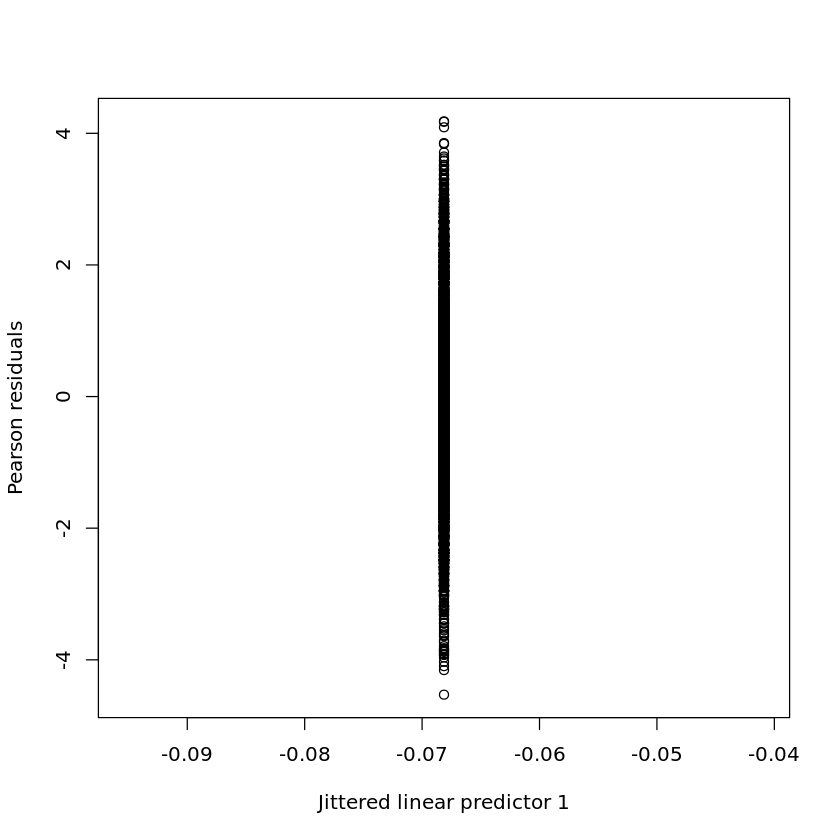

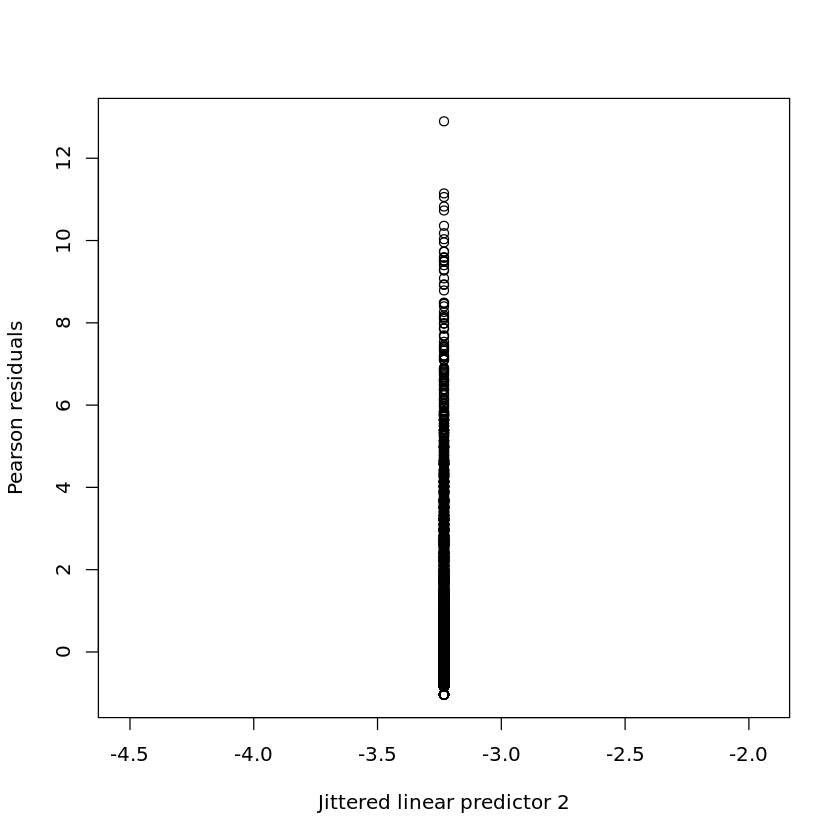

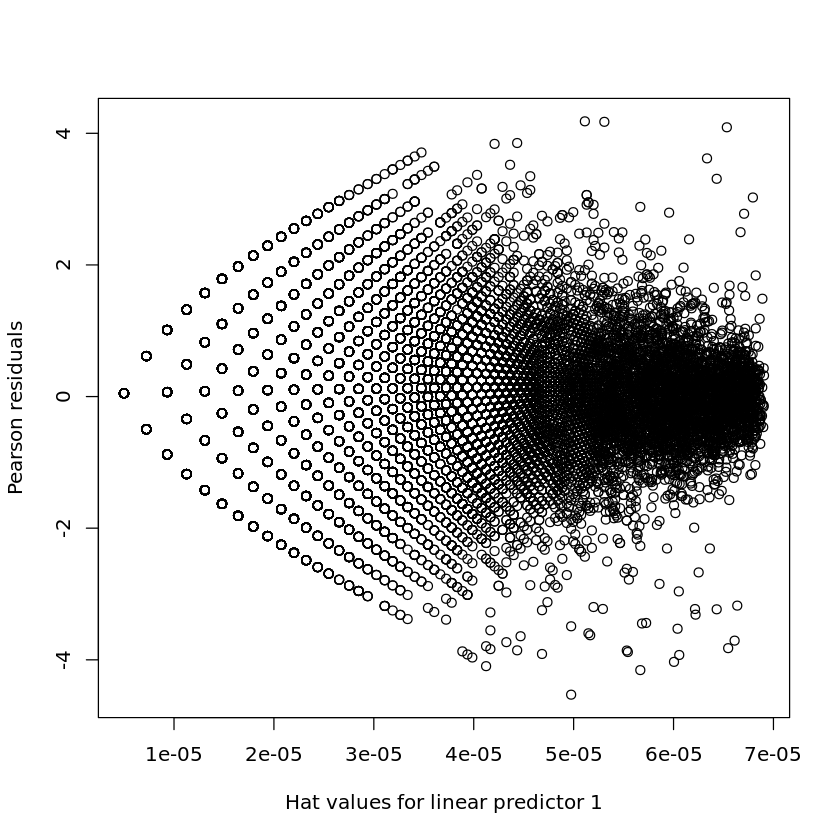

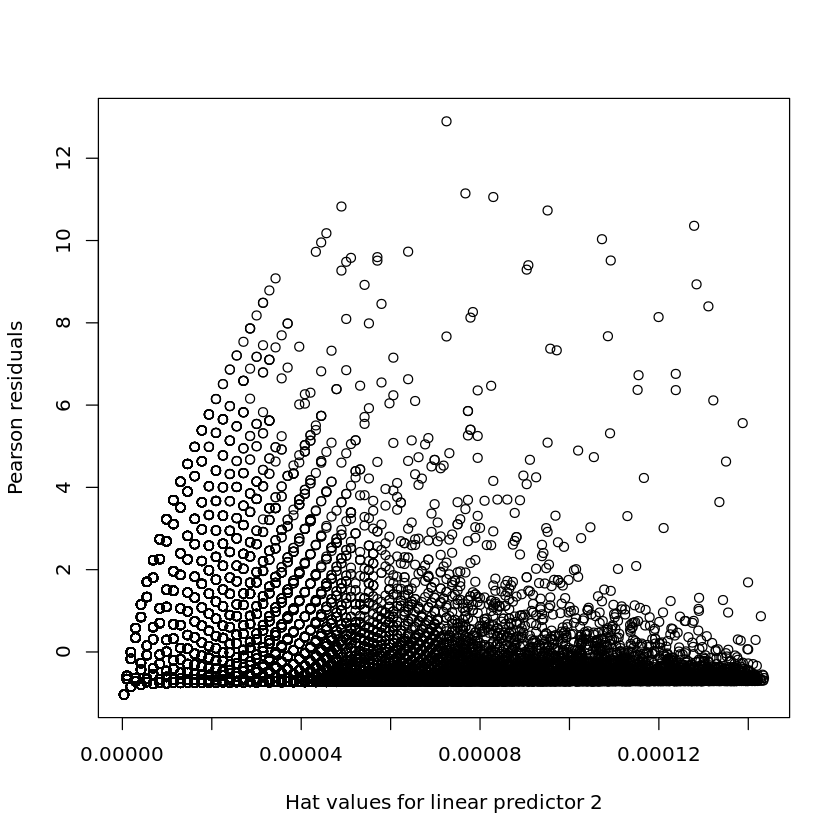

In [7]:
# example of a better one, not perfect tho
VGAM::plot(betabinom_fit_3) # https://online.stat.psu.edu/stat504/book/export/html/778
# https://library.virginia.edu/data/articles/diagnostic-plots

In [8]:
betabinom_fit_rho_bad_model = VGAM::vglm(cbind(sub_counts[[rep1]], sub_counts[[rep2]]) ~ sub_counts$total_reads,
                       VGAM::betabinomial(zero=NULL), trace = TRUE) # rho as a function to total reads


VGLM    linear loop  1 :  loglikelihood = -92318.9952
VGLM    linear loop  2 :  loglikelihood = -92371.3406
Taking a modified step..
VGLM    linear loop  2 :  loglikelihood = -92310.1203
VGLM    linear loop  3 :  loglikelihood = -92278.7016
VGLM    linear loop  4 :  loglikelihood = -92283.9472
Taking a modified step.
VGLM    linear loop  4 :  loglikelihood = -92277.3742
VGLM    linear loop  5 :  loglikelihood = -92280.7918
Taking a modified step.
VGLM    linear loop  5 :  loglikelihood = -92276.2197
VGLM    linear loop  6 :  loglikelihood = -92278.105
Taking a modified step.
VGLM    linear loop  6 :  loglikelihood = -92276.0952
VGLM    linear loop  7 :  loglikelihood = -92277.5129
Taking a modified step.
VGLM    linear loop  7 :  loglikelihood = -92275.9377
VGLM    linear loop  8 :  loglikelihood = -92276.9687
Taking a modified step.
VGLM    linear loop  8 :  loglikelihood = -92275.9185
VGLM    linear loop  9 :  loglikelihood = -92276.7084
Taking a modified step.
VGLM    linear loop  9

Warning message in vglm.fitter(x = x, y = y, w = w, offset = offset, Xm2 = Xm2, :
“some quantities such as z, residuals, SEs may be inaccurate due to convergence at a half-step”
Warning message in vglm.fitter(x = x, y = y, w = w, offset = offset, Xm2 = Xm2, :
“convergence not obtained in 30 IRLS iterations”


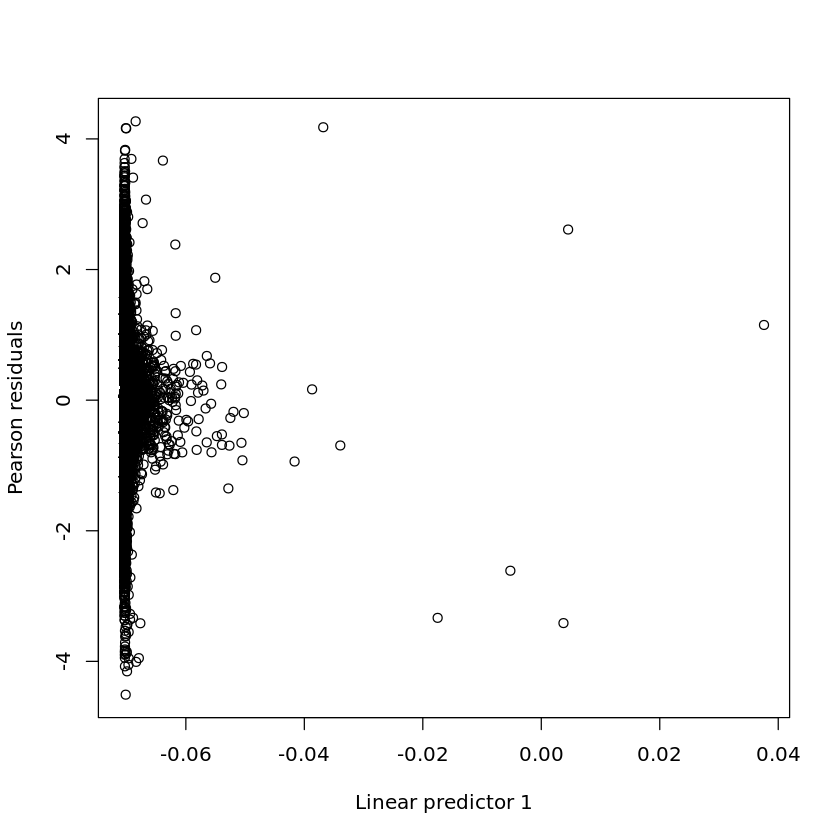

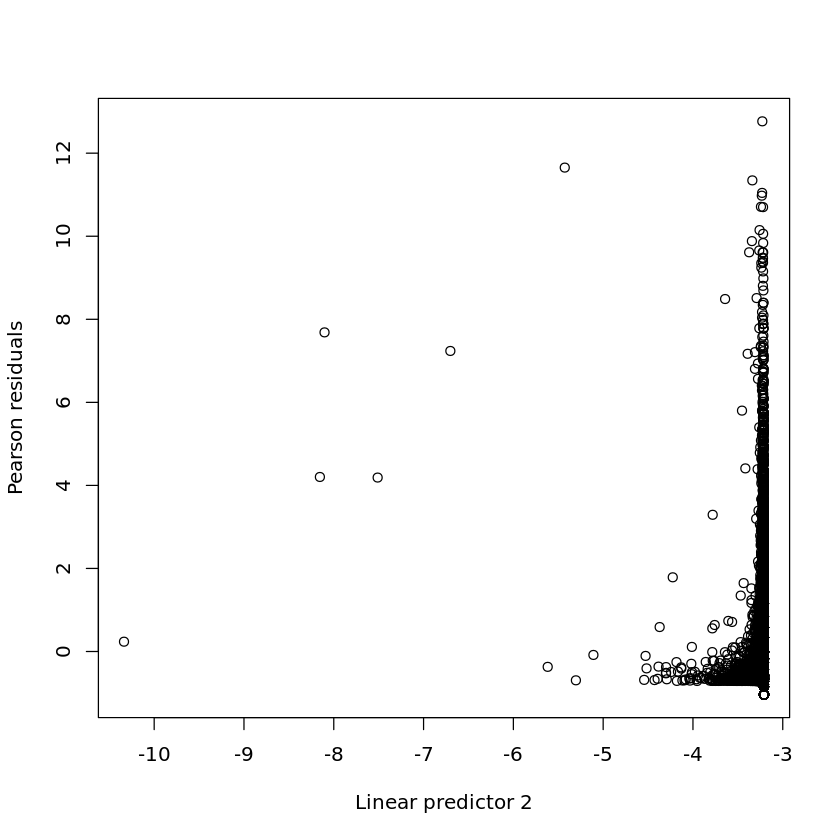

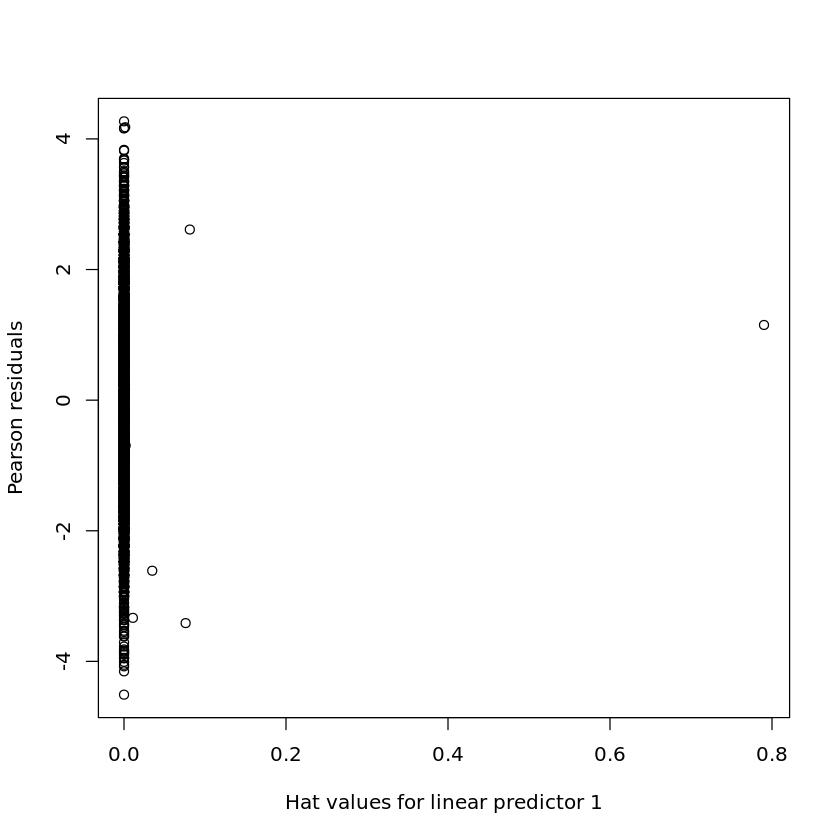

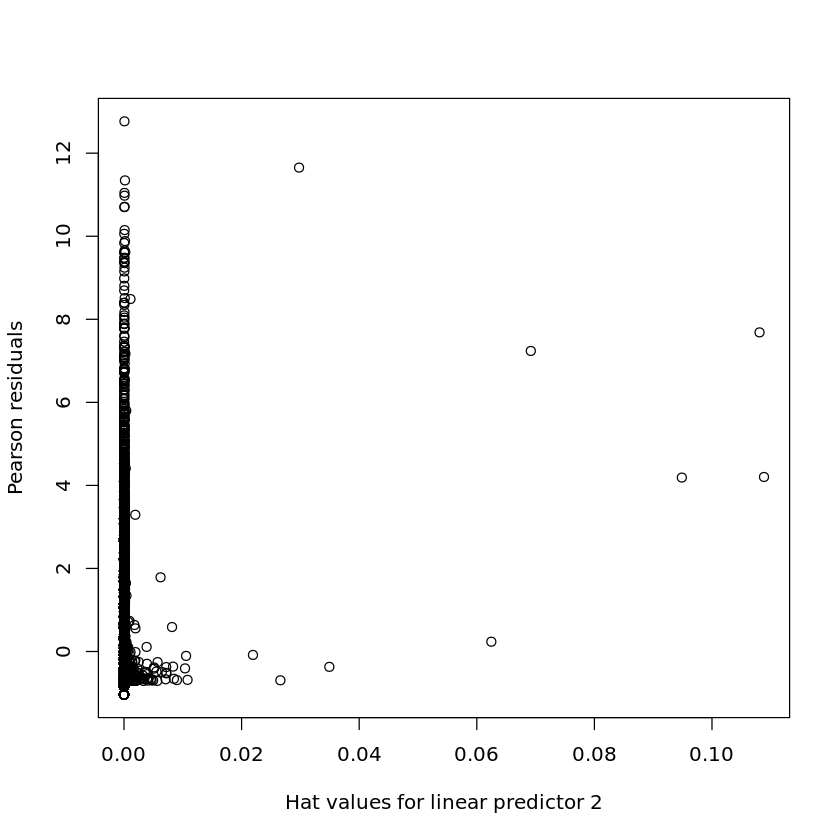

In [9]:
VGAM::plot(betabinom_fit_rho_bad_model) # it is still enigamatic for me .... don't worry let's evaluate in another python notebook